# Chi-Squared Test

The Chi-Squared test is a statistical hypothesis test used to determine if there is a significant association between two categorical variables. It's commonly used in data analysis to test the independence of variables.

## Chi-Squared Test Theory

### Formula

The chi-squared statistic is calculated as:

$$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

Where:
- $O_{ij}$ is the observed frequency count in cell (i,j)
- $E_{ij}$ is the expected frequency count in cell (i,j)
- $r$ is the number of rows
- $c$ is the number of columns

### Expected Frequency

The expected frequency for each cell is calculated as:

$$E_{ij} = \frac{\text{row total} \times \text{column total}}{\text{grand total}}$$

### Degrees of Freedom

For a contingency table with $r$ rows and $c$ columns:

$$df = (r - 1) \times (c - 1)$$

### Hypothesis

- $H_0$ (Null Hypothesis): The variables are independent (no association)
- $H_1$ (Alternative Hypothesis): The variables are dependent (there is an association)

### Decision Rule

Reject $H_0$ if the p-value is less than the significance level (typically 0.05).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, chi2
import random

## Generate Sample Dataset

Let's create a function to generate a sample dataset for chi-squared test. The dataset will simulate a study on the relationship between gender and preference for different types of food.

In [2]:
def generate_chi_squared_dataset(
    n_observations=200, categories=None, dependency_strength=0.3, random_seed=42
):
    """
    Generate a sample dataset for chi-squared test with configurable parameters.

    Parameters:
    -----------
    n_observations : int, default=200
        Number of observations in the dataset
    categories : dict, default=None
        Dictionary with category names as keys and list of values as values
        If None, default categories will be used
    dependency_strength : float, default=0.3
        Controls how strong the dependency is between variables (0 = independent, 1 = perfect dependency)
    random_seed : int, default=42
        Random seed for reproducibility

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing generated categorical data
    """
    np.random.seed(random_seed)
    random.seed(random_seed)

    if categories is None:
        # Default categories - gender and food preference
        categories = {
            "gender": ["Male", "Female"],
            "food_preference": ["Italian", "Chinese", "Mexican", "Indian"],
        }

    data = {}

    # Generate the first category independently
    first_cat_name = list(categories.keys())[0]
    first_cat_values = categories[first_cat_name]
    data[first_cat_name] = np.random.choice(first_cat_values, size=n_observations)

    # Generate the second category with some dependency on the first
    second_cat_name = list(categories.keys())[1]
    second_cat_values = categories[second_cat_name]

    data[second_cat_name] = []
    for i in range(n_observations):
        # Determine if this observation will follow the dependency pattern
        if np.random.random() < dependency_strength:
            # Create dependency - each value in first category prefers specific values in second category
            first_val_index = first_cat_values.index(data[first_cat_name][i])
            preferred_indices = [
                (first_val_index + j) % len(second_cat_values)
                for j in range(len(second_cat_values) // 2 + 1)
            ]
            preferred_values = [second_cat_values[idx] for idx in preferred_indices]
            data[second_cat_name].append(np.random.choice(preferred_values))
        else:
            # Random choice (independent)
            data[second_cat_name].append(np.random.choice(second_cat_values))

    return pd.DataFrame(data)

In [3]:
# Generate a sample dataset
df = generate_chi_squared_dataset(n_observations=300, dependency_strength=0.4)
print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (300, 2)


,gender,food_preference
0,Male,Mexican
1,Female,Italian
2,Male,Indian
3,Male,Mexican
4,Male,Mexican
5,Female,Chinese
6,Male,Indian
7,Male,Chinese
8,Male,Mexican
9,Female,Indian


## Create Contingency Table

A contingency table shows the relationship between two categorical variables. It's the primary input for a chi-squared test.

In [4]:
# Create a contingency table
contingency_table = pd.crosstab(df["gender"], df["food_preference"])
print("Contingency Table (Observed Frequencies):")
contingency_table

Contingency Table (Observed Frequencies):


food_preference,Chinese,Indian,Italian,Mexican
gender,,,,
Female,35,45,27,42
Male,36,26,56,33


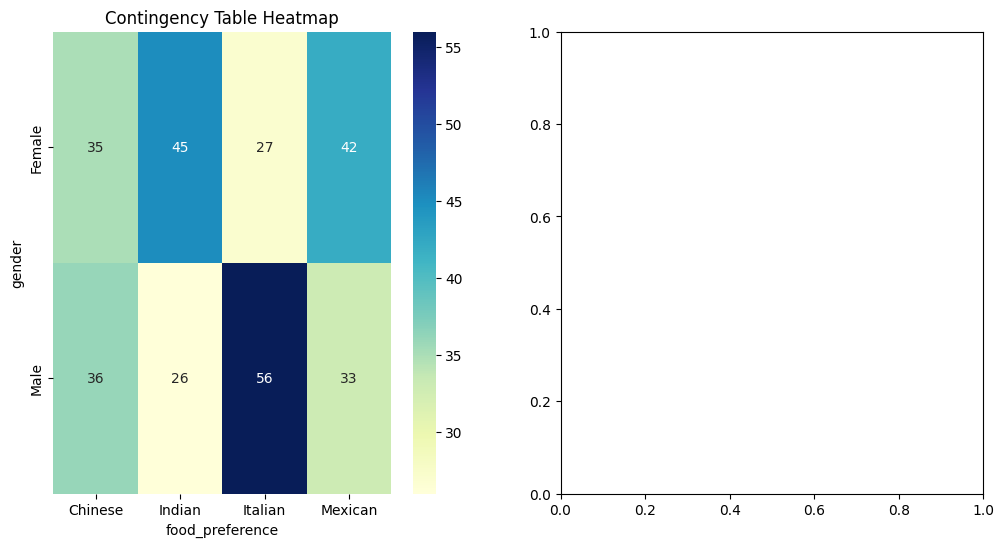

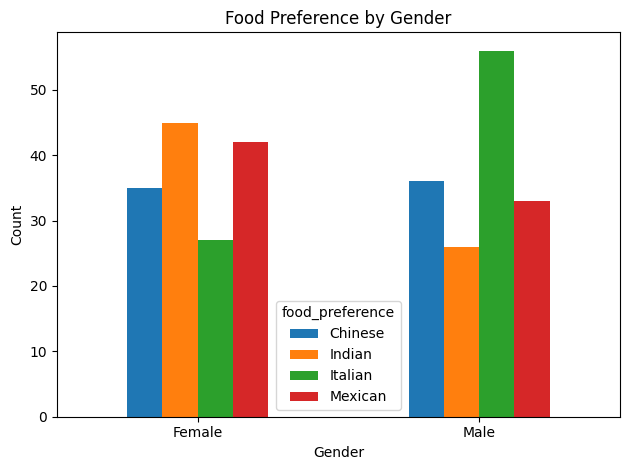

In [5]:
# Visualize the data
plt.figure(figsize=(12, 6))

# Plot 1: Contingency table as heatmap
plt.subplot(1, 2, 1)
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Contingency Table Heatmap")

# Plot 2: Bar chart comparison
plt.subplot(1, 2, 2)
contingency_table.plot(kind="bar", stacked=False)
plt.title("Food Preference by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Chi-Squared Test Implementation

### 1. Using SciPy Library

In [6]:
def chi_squared_test_scipy(contingency_table, alpha=0.05):
    """
    Perform chi-squared test using scipy.stats.

    Parameters:
    -----------
    contingency_table : pandas.DataFrame or numpy.ndarray
        The contingency table of observed frequencies
    alpha : float, default=0.05
        Significance level

    Returns:
    --------
    dict
        Dictionary containing test results
    """
    # Perform chi-squared test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Format expected frequencies table
    if isinstance(contingency_table, pd.DataFrame):
        expected_table = pd.DataFrame(
            expected, index=contingency_table.index, columns=contingency_table.columns
        )
    else:
        expected_table = expected

    # Determine if we reject the null hypothesis
    reject_null = p_value < alpha

    # Critical value for given alpha and degrees of freedom
    critical_value = chi2.ppf(1 - alpha, dof)

    return {
        "chi2_statistic": chi2_stat,
        "p_value": p_value,
        "degrees_of_freedom": dof,
        "expected_frequencies": expected_table,
        "critical_value": critical_value,
        "reject_null_hypothesis": reject_null,
        "conclusion": (
            "Reject null hypothesis (variables are dependent)"
            if reject_null
            else "Fail to reject null hypothesis (variables are independent)"
        ),
    }

In [7]:
# Run chi-squared test using SciPy
scipy_results = chi_squared_test_scipy(contingency_table)

# Display results
print("Chi-Squared Test Results (SciPy):")
print(f"Chi-squared statistic: {scipy_results['chi2_statistic']:.4f}")
print(f"P-value: {scipy_results['p_value']:.4f}")
print(f"Degrees of freedom: {scipy_results['degrees_of_freedom']}")
print(f"Critical value (α=0.05): {scipy_results['critical_value']:.4f}")
print(f"Conclusion: {scipy_results['conclusion']}")

print("\nExpected Frequencies:")
scipy_results["expected_frequencies"]

Chi-Squared Test Results (SciPy):
Chi-squared statistic: 16.2985
P-value: 0.0010
Degrees of freedom: 3
Critical value (α=0.05): 7.8147
Conclusion: Reject null hypothesis (variables are dependent)

Expected Frequencies:


food_preference,Chinese,Indian,Italian,Mexican
gender,,,,
Female,35.263333,35.263333,41.223333,37.25
Male,35.736667,35.736667,41.776667,37.75


### 2. Pure Python Implementation

Now, let's implement the chi-squared test from scratch using Python.

In [8]:
def chi_squared_test_python(observed, alpha=0.05):
    """
    Perform chi-squared test using pure Python.

    Parameters:
    -----------
    observed : pandas.DataFrame or numpy.ndarray
        The contingency table of observed frequencies
    alpha : float, default=0.05
        Significance level

    Returns:
    --------
    dict
        Dictionary containing test results
    """
    # Convert to numpy array if it's a DataFrame
    if isinstance(observed, pd.DataFrame):
        observed_array = observed.values
        row_names = observed.index
        col_names = observed.columns
    else:
        observed_array = observed
        row_names = range(observed.shape[0])
        col_names = range(observed.shape[1])

    # Get dimensions
    n_rows, n_cols = observed_array.shape

    # Calculate row and column totals
    row_totals = observed_array.sum(axis=1)
    col_totals = observed_array.sum(axis=0)
    grand_total = observed_array.sum()

    # Calculate expected frequencies
    expected_array = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            expected_array[i, j] = row_totals[i] * col_totals[j] / grand_total

    # Create DataFrame for expected frequencies if input was DataFrame
    if isinstance(observed, pd.DataFrame):
        expected = pd.DataFrame(expected_array, index=row_names, columns=col_names)
    else:
        expected = expected_array

    # Calculate chi-squared statistic
    chi2_stat = 0
    for i in range(n_rows):
        for j in range(n_cols):
            o = observed_array[i, j]
            e = expected_array[i, j]
            chi2_stat += (o - e) ** 2 / e

    # Calculate degrees of freedom
    dof = (n_rows - 1) * (n_cols - 1)

    # Calculate p-value using scipy.stats.chi2
    p_value = 1 - chi2.cdf(chi2_stat, dof)

    # Critical value for given alpha and degrees of freedom
    critical_value = chi2.ppf(1 - alpha, dof)

    # Determine if we reject the null hypothesis
    reject_null = p_value < alpha

    return {
        "chi2_statistic": chi2_stat,
        "p_value": p_value,
        "degrees_of_freedom": dof,
        "expected_frequencies": expected,
        "critical_value": critical_value,
        "reject_null_hypothesis": reject_null,
        "conclusion": (
            "Reject null hypothesis (variables are dependent)"
            if reject_null
            else "Fail to reject null hypothesis (variables are independent)"
        ),
    }

In [9]:
# Run chi-squared test using pure Python
python_results = chi_squared_test_python(contingency_table)

# Display results
print("Chi-Squared Test Results (Pure Python):")
print(f"Chi-squared statistic: {python_results['chi2_statistic']:.4f}")
print(f"P-value: {python_results['p_value']:.4f}")
print(f"Degrees of freedom: {python_results['degrees_of_freedom']}")
print(f"Critical value (α=0.05): {python_results['critical_value']:.4f}")
print(f"Conclusion: {python_results['conclusion']}")

print("\nExpected Frequencies:")
python_results["expected_frequencies"]

Chi-Squared Test Results (Pure Python):
Chi-squared statistic: 16.2985
P-value: 0.0010
Degrees of freedom: 3
Critical value (α=0.05): 7.8147
Conclusion: Reject null hypothesis (variables are dependent)

Expected Frequencies:


food_preference,Chinese,Indian,Italian,Mexican
gender,,,,
Female,35.263333,35.263333,41.223333,37.25
Male,35.736667,35.736667,41.776667,37.75


## Compare Results

Let's compare the results from both implementations to ensure they match:

In [10]:
# Compare key statistics from both methods
comparison = {
    "Chi-squared statistic": {
        "SciPy": scipy_results["chi2_statistic"],
        "Python": python_results["chi2_statistic"],
        "Difference": abs(
            scipy_results["chi2_statistic"] - python_results["chi2_statistic"]
        ),
    },
    "P-value": {
        "SciPy": scipy_results["p_value"],
        "Python": python_results["p_value"],
        "Difference": abs(scipy_results["p_value"] - python_results["p_value"]),
    },
}

comparison_df = pd.DataFrame(comparison)
comparison_df

,Chi-squared statistic,P-value
SciPy,16.298513,9.848648e-04
Python,16.298513,9.848648e-04
Difference,0.000000,4.466913e-17


## Example Usage with Different Parameters

Let's demonstrate how to use the functions with different parameters.

In [11]:
# Create a dataset with custom categories
custom_categories = {
    "education": ["High School", "Bachelor", "Master", "PhD"],
    "income_level": ["Low", "Medium", "High"],
}

# Generate dataset with 500 observations and strong dependency (0.7)
df_custom = generate_chi_squared_dataset(
    n_observations=500,
    categories=custom_categories,
    dependency_strength=0.7,
    random_seed=123,
)

# Display the first few rows
df_custom.head()

,education,income_level
0,Master,Low
1,Bachelor,Medium
2,Master,Low
3,Master,Low
4,High School,Medium


In [12]:
# Create contingency table
custom_contingency = pd.crosstab(df_custom["education"], df_custom["income_level"])

# Display contingency table
print("Contingency Table:")
custom_contingency

Contingency Table:


income_level,High,Low,Medium
education,,,
Bachelor,60,14,59
High School,11,45,51
Master,62,61,12
PhD,12,61,52


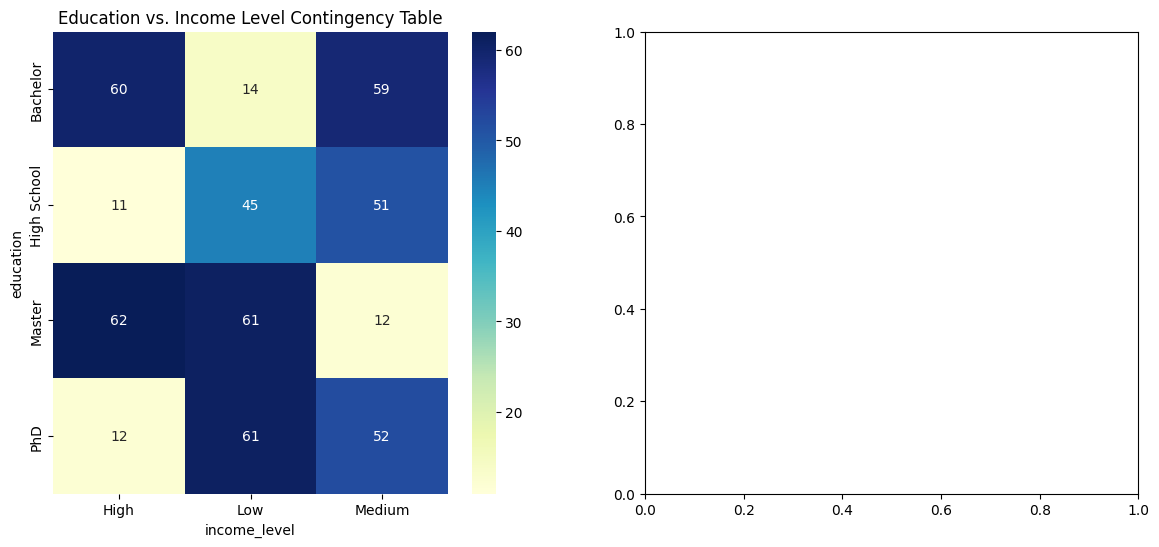

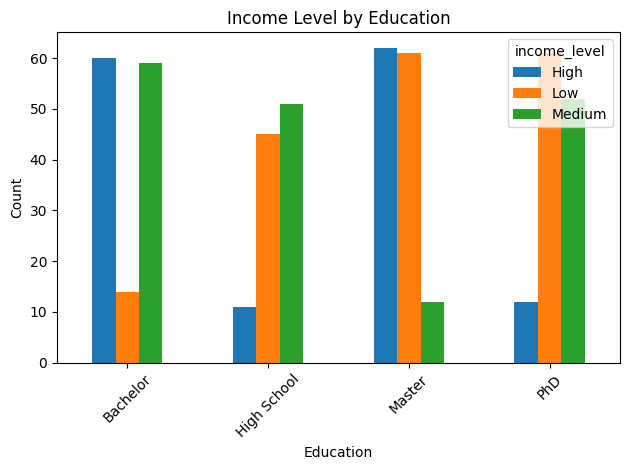

In [13]:
# Visualize the data
plt.figure(figsize=(14, 6))

# Plot 1: Contingency table as heatmap
plt.subplot(1, 2, 1)
sns.heatmap(custom_contingency, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Education vs. Income Level Contingency Table")

# Plot 2: Bar chart comparison
plt.subplot(1, 2, 2)
custom_contingency.plot(kind="bar", stacked=False)
plt.title("Income Level by Education")
plt.xlabel("Education")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
# Run chi-squared test on the custom dataset
custom_results = chi_squared_test_python(custom_contingency)

# Display results
print("Chi-Squared Test Results:")
print(f"Chi-squared statistic: {custom_results['chi2_statistic']:.4f}")
print(f"P-value: {custom_results['p_value']:.4f}")
print(f"Degrees of freedom: {custom_results['degrees_of_freedom']}")
print(f"Conclusion: {custom_results['conclusion']}")

print("\nExpected Frequencies:")
custom_results["expected_frequencies"]

Chi-Squared Test Results:
Chi-squared statistic: 124.4059
P-value: 0.0000
Degrees of freedom: 6
Conclusion: Reject null hypothesis (variables are dependent)

Expected Frequencies:


income_level,High,Low,Medium
education,,,
Bachelor,38.57,48.146,46.284
High School,31.03,38.734,37.236
Master,39.15,48.870,46.980
PhD,36.25,45.250,43.500


## Conclusion

In this notebook, we have:

1. Explained the theory behind the chi-squared test, including its formula and interpretation
2. Created a flexible function to generate sample datasets for chi-squared testing with configurable parameters
3. Implemented the chi-squared test using the SciPy library
4. Implemented the chi-squared test from scratch using pure Python
5. Compared both implementations to ensure accuracy
6. Demonstrated how to use the functions with different parameters and categories

The chi-squared test is a powerful tool for analyzing relationships between categorical variables and helps determine if observed patterns are likely due to chance or represent a significant association.